Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io
from IPython.display import display
from math import pi

ampis_root = str(Path('..','..','..'))
import sys
if ampis_root not in sys.path:
    sys.path.append(ampis_root)

from ampis import analyze, data_utils, powder_char
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset
from ampis import export_anno
from imantics import Polygons, Mask
#import warnings
#warnings.filterwarnings('error')

%matplotlib inline

# Loading Data
For evaluating the segmentation performance, we need to load back the original ground truth labels.

You can use your own predictions generated from before by replacing the paths, but as an example I am including mine from the fully trained model.

In [2]:
root = '../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
sys.path.append(root)
#Loading Ground Truth Labels
satellites_gt_path = Path(ocean_images,'satellite_auto_training_v1.6.json')
for path in [satellites_gt_path]:
    assert path.is_file(), f'File not found : {path}'
satellites_gt_dd = data_utils.get_ddicts('via2', satellites_gt_path, dataset_class='train')
iset_satellites_gt = [InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd]

### Currently not being used because of a problem with local/global variables and Instance Objects

In [3]:
def clean_pred_instance(pred, instance_num):
    data_instance = pred
    removed_index_list = []
    for i in range(len(data_instance['instances'].pred_masks)):
        #intermediary step to convert each RLE instance to a binary mask
        m1 = RLE.decode(data_instance['instances'].pred_masks[i])[:, :]
        m2 = Mask(m1).polygons().points
        try:
            num_points = len(export_anno.split_array(m2[0])[0])
        except:
            print("Error: No points found, deleting annotation")
            num_points = 0
        if num_points < 4:
            removed_index_list.append(i)
    if len(removed_index_list) < 1:
        print('No Removals Required for instance', instance_num)
    else:
        print("Had to remove", len(removed_index_list), 'predicitons from the predicted detections on instance', instance_num)
    for i in range(len(removed_index_list)):
        data_instance['instances'].pred_masks.pop(removed_index_list[i]-i)
        np.delete(data_instance['instances'].pred_boxes, removed_index_list[i]-i)
        data_instance['instances'].num_instances -= 1
    return data_instance

        
def clean_pred_pickle_masks(pred):
    temp_pred = pred
    #for i in range(len(pred)):
    for i in range(10):
        temp_pred[i]['pred'] = clean_pred_instance(pred[i]['pred'], i)
    return temp_pred
#print(satellites_pred)
#satellites_pred = clean_pred_pickle_masks(satellites_pred)
#particle_pred = clean_pred_pickle_masks(particle_pred)

## Load data to InstanceSet objects
To standardize the format of the ground truth and predicted instances, and for convenient analysis, everything is loaded into an InstanceSet class object.

# Powder Characterization- Size Distribution

Once we have the masks it is pretty trivial to compute various properties. With binary masks we can use [skimage regionprops] (https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops), which provides many convenient measurements out of the box. If there are any additional measurements you need, you can also access the masks directly and define your own methods. 

In [4]:
k = ['area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'eccentricity']
for iset in iset_satellites_gt:
    if iset.rprops is None:
        iset.compute_rprops(keys=k)


## Powder Characterization Dataframes
If you wish to see the dataframes for all the images loaded in, uncomment the lines below

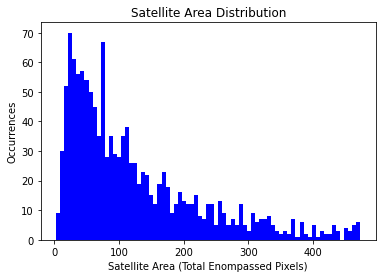

In [11]:
satellite_areas = []
for i in range(len(iset_satellites_gt)):
    for j in iset_satellites_gt[i].rprops['area']:
        satellite_areas.append(j[0])
satellite_areas.sort()
#print(satellite_areas)
powder_char.generate_histogram(powder_char.sort_and_clean(satellite_areas), 75, 'Satellite Area Distribution', 'Satellite Area (Total Enompassed Pixels)', 'Occurrences')
#lt.hist(satellite_areas, 1000)
print('')